# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [114]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [115]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=";")

In [116]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)
#print(azdias.describe())
print(feat_info.shape)
#print(feat_info.describe())

(891221, 85)
(85, 4)


In [117]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [118]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [119]:
a=feat_info['missing_or_unknown'].iloc[0].replace('[','').replace(']','').split(',')

In [120]:
m_or_u_list = [float(x) if x.lstrip('-').isnumeric() else x for x in a]
m_or_u_list

[-1.0, 0.0]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [121]:
# Identify missing or unknown data values and convert them to NaNs.

for atb in feat_info['attribute']:
    atb_list = feat_info[feat_info['attribute']==atb].missing_or_unknown.iloc[0].replace('[','').replace(']','').split(',')
    m_or_u_list = [float(x) if x.lstrip('-').isnumeric() else x for x in a]
    azdias[atb].replace(to_replace=m_or_u_list,value=np.nan,inplace=True)
    

In [122]:
azdias['ANZ_TITEL'].values

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [123]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

azdias.isna().sum().sort_values(ascending=False)

TITEL_KZ                 889061
ANZ_TITEL                888041
SOHO_KZ                  884333
ANZ_HH_TITEL             867252
KBA05_ANTG4              733495
GREEN_AVANTGARDE         715996
AGER_TYP                 685843
KBA05_ANTG3              644869
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
PLZ8_ANTG4               472904
KBA05_ANTG2              425862
KBA05_ANTG1              394373
GEBURTSJAHR              392318
ALTER_HH                 310267
SHOPPER_TYP              238778
PLZ8_ANTG3               236309
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
MOBI_REGIO               133324
KBA05_GBZ                133324
PLZ8_ANTG2               123953
PLZ8_ANTG1               121985
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_GBZ                 116515
HEALTH_TYP               111196
VERS_TYP                 111196
NATIONALITAET_KZ         108315
                          ...  
HH_EINKO

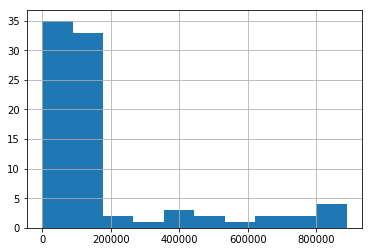

In [124]:
# Investigate patterns in the amount of missing data in each column.
azdias.isna().sum().hist()

In [125]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
column_missing_threshold=300000
drop_columns = list(azdias.isnull().sum()[azdias.isnull().sum()>column_missing_threshold].index)
print("Dropping Columns:",drop_columns)
azdias.drop(drop_columns, axis='columns', inplace=True)

Dropping Columns: ['AGER_TYP', 'GEBURTSJAHR', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'TITEL_KZ', 'ALTER_HH', 'ANZ_TITEL', 'KK_KUNDENTYP', 'ANZ_HH_TITEL', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'PLZ8_ANTG4']


#### Discussion 1.1.2: Assess Missing Data in Each Column

Out of 85 columns, 15 columns have more than half of the rows (445,000) which are empty. Printing thos above and dropping them.
About 35 columns have almost all the data very few NAN.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

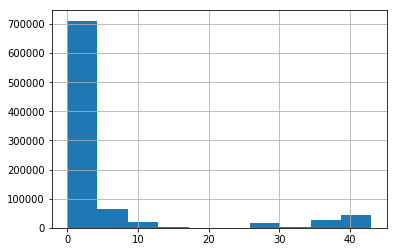

In [126]:
# How much data is missing in each row of the dataset?

azdias.isna().sum(axis=1).sort_values(ascending=False).hist()


In [127]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 20
lower_threshold = azdias.drop(azdias[azdias.isna().sum(axis=1)>threshold].index)
upper_threshold = azdias.drop(azdias[azdias.isna().sum(axis=1)<=threshold].index)


In [128]:
azdias[azdias.isna().sum(axis=1)>25].index

Int64Index([     0,     11,     14,     17,     24,     30,     35,     46,
                48,     53,
            ...
            891100, 891130, 891137, 891140, 891159, 891164, 891171, 891175,
            891185, 891187],
           dtype='int64', length=93156)

In [129]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
lower_threshold.isna().sum()[lower_threshold.isna().sum()==0]
print("Size of lower_threshold:",lower_threshold.size)
print("Size of upper threshold:",upper_threshold.size)

Size of lower_threshold: 55853910
Size of upper threshold: 6531560


In [130]:
lower_threshold.isna().sum()[lower_threshold.isna().sum()==0]

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
HH_EINKOMMEN_SCORE       0
WOHNDAUER_2008           0
GEBAEUDETYP              0
MIN_GEBAEUDEJAHR         0
OST_WEST_KZ              0
dtype: int64

In [131]:
upper_threshold.isna().sum()[upper_threshold.isna().sum()==0]

ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
dtype: int64

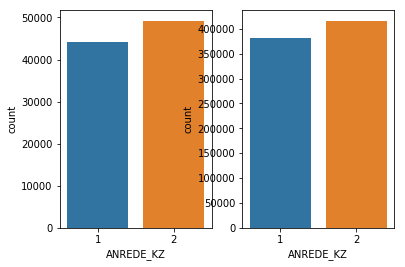

In [132]:
def plotchart(column):
    
    ax1 = plt.subplot(1,2,1)
    sns.countplot(upper_threshold[column], ax=ax1)
    ax2 = plt.subplot(1,2,2)
    sns.countplot(lower_threshold[column], ax=ax2)
plotchart('ANREDE_KZ')

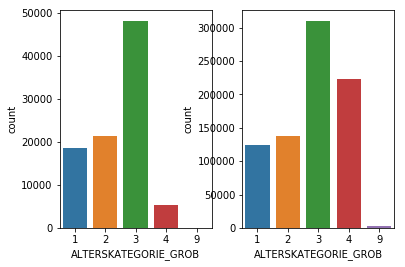

In [133]:
plotchart('ALTERSKATEGORIE_GROB')

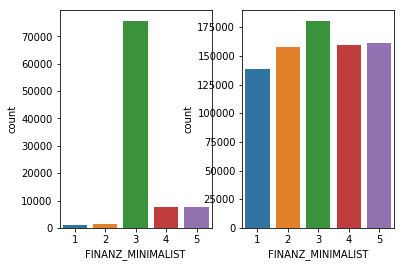

In [134]:
plotchart('FINANZ_MINIMALIST')

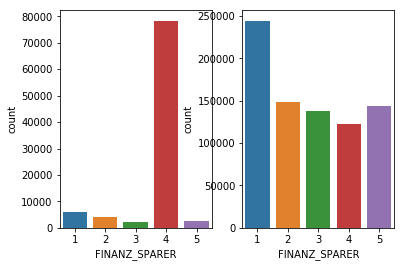

In [135]:
plotchart('FINANZ_SPARER')

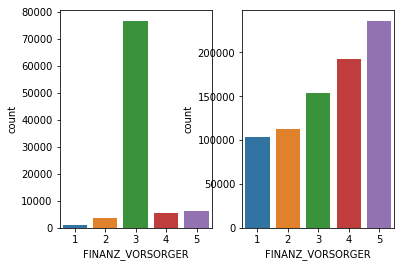

In [136]:
plotchart('FINANZ_VORSORGER')

#### Discussion 1.1.3: Assess Missing Data in Each Row

Upper threshold data has missing values in almost all of the columns in first five columns, which means it has missing data uniformly, however the lower threshold has missing values majorly in one or two feature sets which are dominating.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [137]:
feat_info['type']

0     categorical
1         ordinal
2     categorical
3     categorical
4         ordinal
5         ordinal
6         ordinal
7         ordinal
8         ordinal
9         ordinal
10    categorical
11        numeric
12    categorical
13    categorical
14        ordinal
15          mixed
16          mixed
17    categorical
18    categorical
19    categorical
20    categorical
21    categorical
22          mixed
23        ordinal
24        ordinal
25        ordinal
26        ordinal
27        ordinal
28        ordinal
29        ordinal
         ...     
55    categorical
56          mixed
57    categorical
58    categorical
59          mixed
60        ordinal
61        ordinal
62        ordinal
63        ordinal
64          mixed
65        ordinal
66        ordinal
67        ordinal
68        ordinal
69        ordinal
70        ordinal
71        ordinal
72        ordinal
73        ordinal
74        numeric
75        ordinal
76        ordinal
77        ordinal
78        ordinal
79        

In [138]:
# How many features are there of each data type?
feat_info.groupby(['type']).count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [139]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
for atb in feat_info[feat_info['type']=='categorical'].attribute:
    if atb in azdias.columns:
        print(atb,azdias[atb].nunique())

ANREDE_KZ 2
CJT_GESAMTTYP 6
FINANZTYP 6
GFK_URLAUBERTYP 12
LP_FAMILIE_FEIN 11
LP_FAMILIE_GROB 5
LP_STATUS_FEIN 10
LP_STATUS_GROB 5
NATIONALITAET_KZ 3
SHOPPER_TYP 3
VERS_TYP 2
ZABEOTYP 6
GEBAEUDETYP 7
OST_WEST_KZ 2
CAMEO_DEUG_2015 10
CAMEO_DEU_2015 45


In [140]:
#Find out which one is non numerical and binary
for atb in feat_info[feat_info['type']=='categorical'].attribute:
    if atb in azdias.columns:
        if azdias[atb].nunique()==2:
            print (atb,azdias[atb].unique())

ANREDE_KZ [1 2]
VERS_TYP [ nan   2.   1.]
OST_WEST_KZ [nan 'W' 'O']


In [141]:
# So ANDREDE_KZ and VERS_TYPE can be kept as is
# OST_WEST_KZ needs to be encoded in dummy variable

In [147]:
# Re-encode categorical variable(s) to be kept in the analysis.
lower_threshold = pd.get_dummies(lower_threshold,columns=['OST_WEST_KZ'])

In [148]:
#drop columns from lower_threshold_new which have multi-level cateogoricals
for atb in feat_info[feat_info['type']=='categorical'].attribute:
    if atb in lower_threshold_new.columns:
        if lower_threshold_new[atb].nunique()>2:
            drop_columns.append(atb)
drop_columns

['AGER_TYP',
 'GEBURTSJAHR',
 'GREEN_AVANTGARDE',
 'SOHO_KZ',
 'TITEL_KZ',
 'ALTER_HH',
 'ANZ_TITEL',
 'KK_KUNDENTYP',
 'ANZ_HH_TITEL',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'PLZ8_ANTG4',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [149]:
lower_threshold.columns.size

71

In [150]:
lower_threshold.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP',
       'ANZ_PERSONEN', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
       'CAMEO_INTL_2015', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',


In [152]:
lower_threshold.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
       'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ',
       'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP',
       'ANZ_PERSONEN', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015',
       'CAMEO_INTL_2015', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',


In [153]:
lower_threshold.columns.size

71

#### Discussion 1.2.1: Re-Encode Categorical Features
- Kept all the binary columns
- Encode the one which was non numeric 'OST_WEST_KZ'
- Dropped all which were multi-level categorical

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [154]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
### 1.18. PRAEGENDE_JUGENDJAHRE
#Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
# -1: unknown
#  0: unknown
#  1: 40s - war years (Mainstream, E+W)
#  2: 40s - reconstruction years (Avantgarde, E+W)
#  3: 50s - economic miracle (Mainstream, E+W)
#  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
#  5: 60s - economic miracle (Mainstream, E+W)
#  6: 60s - generation 68 / student protestors (Avantgarde, W)
#  7: 60s - opponents to the building of the Wall (Avantgarde, E)
#  8: 70s - family orientation (Mainstream, E+W)
#  9: 70s - peace movement (Avantgarde, E+W)
# 10: 80s - Generation Golf (Mainstream, W)
# 11: 80s - ecological awareness (Avantgarde, W)
# 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# 13: 80s - Swords into ploughshares (Avantgarde, E)
# 14: 90s - digital media kids (Mainstream, E+W)
# 15: 90s - ecological awareness (Avantgarde, E+W)
movement = {
    1:[40,0],
    2:[40,1],
    3:[50,0],
    4:[50,1],
    5:[60,0],
    6:[60,1],
    7:[60,1],
    8:[70,0],
    9:[70,1],
    10:[80,0],
    11:[80,1],
    12:[80,0],
    13:[80,1],
    14:[90,0],
    15:[90,1],
    np.nan:[np.nan,np.nan]
}
movement[1][:]

[40, 0]

In [155]:
for col in lower_threshold_new.columns: print (col)

ALTERSKATEGORIE_GROB
ANREDE_KZ
CJT_GESAMTTYP
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GFK_URLAUBERTYP
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
PRAEGENDE_JUGENDJAHRE
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SHOPPER_TYP
VERS_TYP
ZABEOTYP
ANZ_PERSONEN
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
GEBAEUDETYP
KONSUMNAEHE
MIN_GEBAEUDEJAHR
WOHNLAGE
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_BAUMAX
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
OST_WEST_KZ_O
OST_WEST_KZ_W


In [156]:
lower_threshold_new['DECADE'] = lower_threshold_new['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else movement[x][0])
lower_threshold_new['MOVEMENT']=lower_threshold_new['PRAEGENDE_JUGENDJAHRE'].apply(lambda x:np.nan if np.isnan(x) else movement[x][1])

In [157]:
lower_threshold_new.drop('PRAEGENDE_JUGENDJAHRE', axis='columns', inplace=True)

In [158]:
lower_threshold_new['MOVEMENT'].head()

1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: MOVEMENT, dtype: float64

In [160]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
lower_threshold_new['CAMEO_INTL_2015_10s'] = lower_threshold_new['CAMEO_INTL_2015'].str[0]
lower_threshold_new['CAMEO_INTL_2015_1s'] = lower_threshold_new['CAMEO_INTL_2015'].str[1]


In [161]:
lower_threshold_new['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [162]:
lower_threshold_new['CAMEO_INTL_2015_10s'].head()

1    5
2    2
3    1
4    4
5    5
Name: CAMEO_INTL_2015_10s, dtype: object

In [163]:
lower_threshold_new.drop('CAMEO_INTL_2015',axis='columns',inplace=True)

In [164]:
# remove all mixed attributes except PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
for attribute in feat_info[feat_info['type']=='mixed'].attribute:
    drop_columns.append(attribute)

In [165]:
drop_columns.remove('PRAEGENDE_JUGENDJAHRE')
drop_columns.remove('CAMEO_INTL_2015')

In [166]:
drop_columns

['AGER_TYP',
 'GEBURTSJAHR',
 'GREEN_AVANTGARDE',
 'SOHO_KZ',
 'TITEL_KZ',
 'ALTER_HH',
 'ANZ_TITEL',
 'KK_KUNDENTYP',
 'ANZ_HH_TITEL',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'PLZ8_ANTG4',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'WOHNLAGE',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

#### Discussion 1.2.2: Engineer Mixed-Type Features

- Replaced PRAEGENDE_JUGENDJAHRE to DECADE and MOVEMENT
- Replaced CAMEO_INTL_2015 to CAMEO_INTL_2015_10s and CAMEO_INTL_2015_1s

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [174]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    #lstrip is to cut the '-' sign in the string
    #isnumeric checks whether it is number or not
    for attribute in feat_info['attribute']:
        tmp_list = feat_info[feat_info['attribute']==attribute].missing_or_unknown.iloc[0].replace('[','').replace(']','').split(',')
        missing_or_unknown_list = [float(x) if x.lstrip('-').isnumeric() else x for x in tmp_list]
        df[attribute].replace(to_replace=missing_or_unknown_list,
                      value=np.nan, inplace=True)

    # remove selected columns and rows, ...    
    
    df.drop(drop_columns, axis='columns', inplace=True)
    
    # select, re-encode, and engineer column values.
    df = pd.get_dummies(df, columns=['OST_WEST_KZ'])

    df['GENERATION'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else movement[x][0])

    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else movement[x][1])

    df.drop('PRAEGENDE_JUGENDJAHRE', axis='columns', inplace=True)

    df['CAMEO_INTL_2015_tens'] = df['CAMEO_INTL_2015'].str[0]
    df['CAMEO_INTL_2015_ones'] = df['CAMEO_INTL_2015'].str[1]
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    lower_threshold = df.drop(df[df.isnull().sum(axis=1)>25].index)
    upper_threshold = df.drop(df[df.isnull().sum(axis=1)<=25].index)
    
    # Return the cleaned dataframe.
    return lower_threshold

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [175]:
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

In [176]:
df = clean_data(azdias)
from sklearn.preprocessing import Imputer
imp = Imputer()
imp = imp.fit(df)
clean_df = imp.transform(df)

In [177]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(clean_df)
new_df = scaler.transform(clean_df)


In [178]:
pca_df = pd.DataFrame(new_df)

In [179]:
pca_df.columns = df.columns
pca_df.index = df.index

In [180]:
pca_df

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,GENERATION,MOVEMENT,CAMEO_INTL_2015_tens,CAMEO_INTL_2015_ones
1,-1.764253,0.957659,-1.509421,1.540905,-1.045423,1.456175,0.940798,1.357196,1.097468e+00,-1.685461,...,5.717708e-01,-1.692553e-01,-1.292083e-01,0.692678,-0.509826,0.545691,1.167006,-5.484669e-01,1.205367,-1.281349e+00
2,0.202122,0.957659,-1.509421,0.866874,-1.772722,-0.580498,0.227303,1.357196,1.097468e+00,-0.304717,...,5.717708e-01,-1.692553e-01,-1.292083e-01,-0.798608,-0.509826,0.545691,1.167006,1.902395e+00,-0.875360,7.709623e-01
3,1.185310,0.957659,0.666045,-0.481189,1.136475,-0.580498,-1.199686,-0.766301,-2.577523e-01,-0.995089,...,5.717708e-01,-1.184669e+00,-1.010008e+00,-0.052965,-0.509826,0.545691,-0.232948,-5.484669e-01,-1.568936,-5.972455e-01
4,0.202122,-1.044213,0.666045,0.192843,0.409175,-1.259388,0.227303,-0.766301,1.097468e+00,1.076026,...,-3.520591e-01,8.461587e-01,3.111915e-01,1.438321,-0.509826,0.545691,-0.232948,-5.484669e-01,0.511791,8.685842e-02
5,-1.764253,0.957659,-0.059110,-1.155220,1.136475,-0.580498,-0.486191,1.357196,1.097468e+00,-0.304717,...,1.495601e+00,-1.184669e+00,-1.010008e+00,-0.052965,-0.509826,0.545691,-1.632902,-5.484669e-01,1.205367,7.709623e-01
6,-0.781066,0.957659,-1.509421,1.540905,-1.772722,1.456175,0.940798,-0.058468,-2.577523e-01,0.385655,...,1.495601e+00,8.461587e-01,3.111915e-01,-0.052965,-0.509826,0.545691,0.467029,-5.484669e-01,-0.875360,-5.972455e-01
7,-1.764253,-1.044213,-0.059110,0.192843,0.409175,-1.259388,0.227303,-0.766301,-1.612973e+00,1.076026,...,5.717708e-01,-1.184669e+00,-1.292083e-01,-0.798608,-0.509826,0.545691,-0.232948,-5.484669e-01,-1.568936,7.709623e-01
8,0.202122,-1.044213,0.666045,0.866874,-1.045423,0.777284,-0.486191,-0.766301,1.097468e+00,0.385655,...,-3.520591e-01,-1.184669e+00,-5.696080e-01,-0.052965,-0.509826,0.545691,0.467029,1.902395e+00,-1.568936,8.685842e-02
9,0.202122,0.957659,-0.784266,0.866874,-1.045423,0.098393,1.654293,0.649364,-2.577523e-01,0.385655,...,-3.520591e-01,-1.184669e+00,-1.010008e+00,-1.544252,-0.509826,0.545691,1.167006,1.902395e+00,-1.568936,1.455066e+00
10,0.202122,0.957659,-0.784266,-0.481189,1.136475,0.098393,-1.199686,1.357196,-2.577523e-01,1.076026,...,-3.520591e-01,8.461587e-01,3.111915e-01,1.438321,-0.509826,0.545691,-1.632902,-5.484669e-01,1.205367,-1.281349e+00


In [202]:
def feature_scaling(df):
    # use existing object imp
    clean_df = imp.transform(df)
    #use existing object scaler
    new_df = scaler.transform(clean_df)
    pca_df = pd.DataFrame(new_df)
    pca_df.columns = df.columns
    pca_df.index = df.index
    return pca_df

### Discussion 2.1: Apply Feature Scaling

Using Imputer and StandardScaler as suggested...

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [183]:
# Apply PCA to the data.

from sklearn.decomposition import PCA
pca = PCA(n_components=35)
pca_X = pca.fit_transform(new_df)

In [184]:
# From helper.py 
def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)




,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,GENERATION,MOVEMENT,CAMEO_INTL_2015_tens,CAMEO_INTL_2015_ones
Dimension 1,0.1679,-0.2230,-0.0220,-0.2376,0.2379,-0.2069,0.1509,0.1650,0.1066,0.0550,...,-0.1342,0.1200,0.1625,0.1115,0.0432,-0.0420,0.2010,-0.0866,0.1689,-0.1214
Dimension 2,0.1468,0.1784,0.1024,-0.0480,-0.1441,0.1556,-0.1500,-0.1712,0.1873,-0.0365,...,-0.1461,0.1406,0.1845,0.1317,0.0526,-0.0477,-0.1794,-0.0558,0.1675,-0.0588
Dimension 3,0.1081,0.0836,-0.3651,0.1457,-0.1081,0.1039,-0.1917,-0.1068,-0.0253,-0.0288,...,-0.0500,0.0477,0.0568,0.0417,0.0239,-0.0214,-0.1134,0.0290,0.0438,-0.0161
Dimension 4,0.0531,0.0305,-0.0078,-0.0503,0.0117,-0.0465,0.1663,-0.1098,0.1139,-0.0189,...,-0.1843,0.0760,-0.2054,-0.0515,0.3249,-0.3186,-0.0188,-0.2989,0.1240,-0.0323
Dimension 5,0.0440,-0.0134,0.0195,0.1329,-0.0293,-0.0830,-0.0359,-0.0310,-0.1243,-0.0053,...,-0.2768,0.2316,0.1745,0.1265,0.2775,-0.2796,0.0351,0.2336,-0.1224,0.1118
Dimension 6,0.0353,-0.0026,0.0350,-0.0638,-0.0191,-0.0641,0.0093,-0.0691,0.1770,-0.1245,...,0.1511,0.0064,-0.0894,-0.1535,0.3747,-0.3723,-0.0418,0.0176,-0.0391,0.0975
Dimension 7,0.0306,0.0577,-0.0482,0.0342,0.0559,-0.0965,0.1246,-0.0125,-0.0875,0.1100,...,0.2356,0.2116,0.0859,0.0735,0.2256,-0.2253,0.0981,0.0021,0.0353,-0.0065
Dimension 8,0.0273,0.0784,-0.0848,-0.1237,0.1614,-0.1269,0.0958,0.1288,-0.0036,0.2647,...,-0.1371,-0.2383,-0.0912,-0.1748,-0.0348,0.0526,0.1803,0.0035,0.0110,-0.0727
Dimension 9,0.0263,0.1708,0.0400,-0.0371,0.0404,-0.0304,0.0392,0.1061,-0.0425,-0.4498,...,-0.1028,-0.1512,-0.0679,-0.0620,-0.1167,0.0905,0.0428,-0.0238,0.1024,-0.1505
Dimension 10,0.0237,-0.0881,0.0367,-0.0464,-0.0629,0.1284,-0.0103,-0.1951,0.2047,0.0410,...,-0.0226,-0.1026,-0.0284,-0.1194,0.0243,-0.0031,-0.0875,-0.0020,0.0213,0.0356


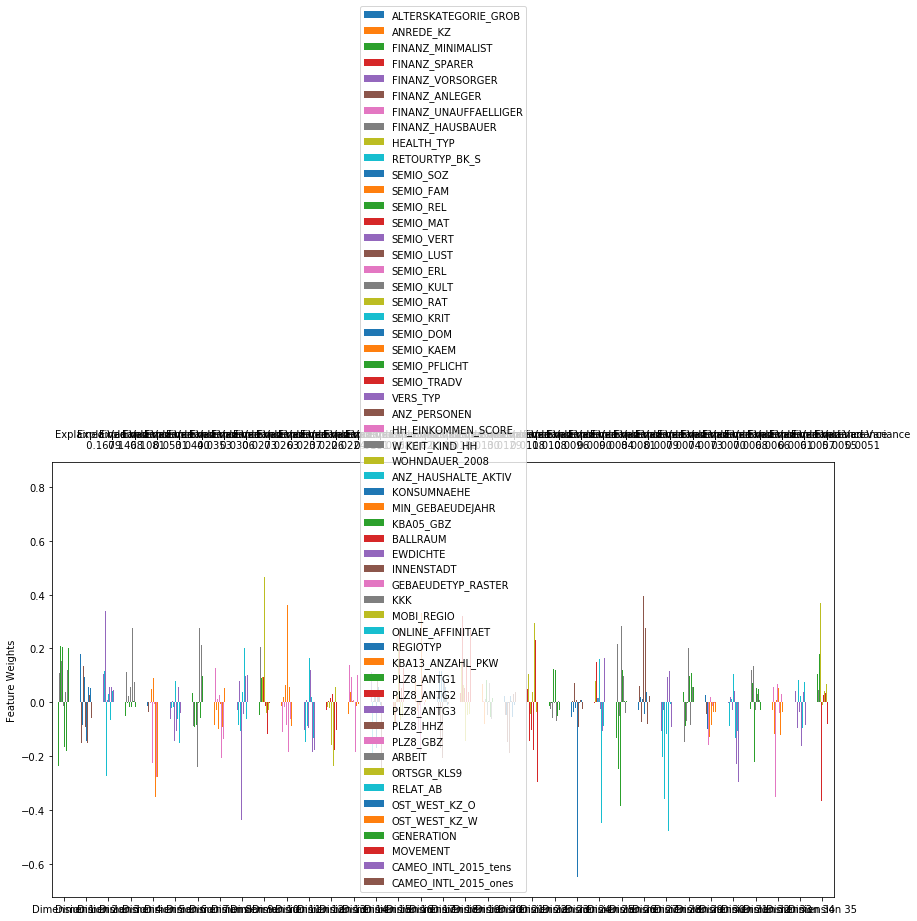

In [185]:
# Investigate the variance accounted for by each principal component.
pca_results(pca_df, pca)

In [186]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.16791073,  0.31468459,  0.42279709,  0.47593803,  0.51993366,
        0.55527331,  0.58585292,  0.61316573,  0.6394477 ,  0.66311047,
        0.6857105 ,  0.70808629,  0.72619032,  0.74294932,  0.75919637,
        0.77373495,  0.78756354,  0.80060456,  0.81349083,  0.82528202,
        0.8361282 ,  0.84571264,  0.85466306,  0.86308293,  0.87115695,
        0.87907068,  0.88647989,  0.89378004,  0.90081427,  0.90766206,
        0.91422808,  0.92036448,  0.9260488 ,  0.93157153,  0.93671049])

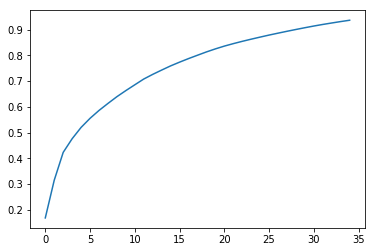

In [187]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [189]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=29)
pca_reduced = pca.fit(pca_df)
pca_X = pca.transform(pca_df)
np.cumsum(pca.explained_variance_ratio_)


array([ 0.16791073,  0.31468459,  0.42279709,  0.47593803,  0.51993366,
        0.55527331,  0.58585291,  0.61316572,  0.63944768,  0.66311044,
        0.68571047,  0.70808625,  0.72619024,  0.74294923,  0.75919618,
        0.77373467,  0.78756251,  0.80060203,  0.81348739,  0.82527797,
        0.83612011,  0.845702  ,  0.85464314,  0.86305936,  0.87112874,
        0.87900696,  0.88639664,  0.89367018,  0.90069011])

In [195]:
pca_X_df = pd.DataFrame(data=pca_X)


### Discussion 2.2: Perform Dimensionality Reduction

If I keep 29 features, I am able to cumulative variance of over 90%, based on MINI-PCA, lab I am going to take 29 features to move forward

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [194]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def map_weight(df, component):
    pca_df = pd.DataFrame(pca.components_, columns=list(df.columns))
    pca_component = pd.DataFrame(pca_df.iloc[component])
    print(pca_component.sort_values(component, ascending=False))
map_weight(pca_df, 0)

                              0
FINANZ_SPARER          0.237893
SEMIO_REL              0.210264
SEMIO_PFLICHT          0.205160
GENERATION             0.200956
PLZ8_ANTG3             0.182244
SEMIO_TRADV            0.181541
HH_EINKOMMEN_SCORE     0.169632
CAMEO_INTL_2015_tens   0.168925
FINANZ_UNAUFFAELLIGER  0.165023
SEMIO_RAT              0.164337
ORTSGR_KLS9            0.162491
EWDICHTE               0.159523
SEMIO_KULT             0.154238
FINANZ_ANLEGER         0.150861
SEMIO_FAM              0.143842
SEMIO_MAT              0.138639
PLZ8_ANTG2             0.127177
ARBEIT                 0.120036
RELAT_AB               0.111526
FINANZ_HAUSBAUER       0.106643
ANZ_HAUSHALTE_AKTIV    0.103066
SEMIO_SOZ              0.079099
REGIOTYP               0.061250
HEALTH_TYP             0.054993
OST_WEST_KZ_O          0.043167
KKK                    0.039167
PLZ8_HHZ               0.032433
ONLINE_AFFINITAET      0.026054
VERS_TYP               0.012435
SEMIO_DOM              0.001167
SEMIO_KA

In [192]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weight(pca_df, 2)

                              2
SEMIO_VERT             0.339424
SEMIO_SOZ              0.258392
SEMIO_FAM              0.248229
SEMIO_KULT             0.233259
FINANZ_MINIMALIST      0.145710
RETOURTYP_BK_S         0.114221
FINANZ_VORSORGER       0.103934
W_KEIT_KIND_HH         0.099285
ALTERSKATEGORIE_GROB   0.083594
SEMIO_LUST             0.068538
SEMIO_REL              0.065814
PLZ8_ANTG3             0.057865
SEMIO_MAT              0.057402
ORTSGR_KLS9            0.056807
EWDICHTE               0.055742
ARBEIT                 0.047736
CAMEO_INTL_2015_tens   0.043762
RELAT_AB               0.041698
PLZ8_ANTG2             0.040289
ANZ_HAUSHALTE_AKTIV    0.032149
WOHNDAUER_2008         0.031971
MOVEMENT               0.028977
OST_WEST_KZ_O          0.023886
VERS_TYP               0.007802
REGIOTYP               0.005578
PLZ8_HHZ               0.002345
HH_EINKOMMEN_SCORE     0.000228
KKK                   -0.005415
CAMEO_INTL_2015_ones  -0.016066
ANZ_PERSONEN          -0.018148
OST_WEST

In [193]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weight(pca_df, 3)

                              3
OST_WEST_KZ_O          0.324883
KKK                    0.277149
BALLRAUM               0.230426
HH_EINKOMMEN_SCORE     0.208066
REGIOTYP               0.190758
INNENSTADT             0.189799
KONSUMNAEHE            0.177561
FINANZ_ANLEGER         0.166341
CAMEO_INTL_2015_tens   0.123987
FINANZ_HAUSBAUER       0.113912
GEBAEUDETYP_RASTER     0.089739
ARBEIT                 0.075960
W_KEIT_KIND_HH         0.056187
MIN_GEBAEUDEJAHR       0.036944
SEMIO_ERL              0.032399
ANZ_HAUSHALTE_AKTIV    0.031059
ALTERSKATEGORIE_GROB   0.030477
SEMIO_KULT             0.022963
FINANZ_SPARER          0.011682
PLZ8_ANTG1             0.004029
SEMIO_VERT             0.000439
WOHNDAUER_2008        -0.000795
SEMIO_REL             -0.002682
SEMIO_FAM             -0.004874
SEMIO_LUST            -0.006958
ANREDE_KZ             -0.007845
SEMIO_SOZ             -0.008250
SEMIO_KRIT            -0.015012
SEMIO_PFLICHT         -0.018482
GENERATION            -0.018776
HEALTH_T

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [196]:
from sklearn.cluster import KMeans

def fit_kmeans(df,centers):
    kmeans = KMeans(n_clusters=centers)
    
    # run k-means clustering on the data and...
    preds = kmeans.fit_predict(df)
    
    # compute the average within-cluster distances.
    pred_centroids = kmeans.cluster_centers_
    
    centers = pred_centroids[preds]
    distance = np.sqrt(((train_trans - centers) ** 2).sum(axis = 1)).mean()
    distances.append(distance)
    
    return model.score(df)

evaluating for 1 clusters
evaluating for 2 clusters
evaluating for 3 clusters
evaluating for 4 clusters
evaluating for 5 clusters
evaluating for 6 clusters
evaluating for 7 clusters
evaluating for 8 clusters
evaluating for 9 clusters
evaluating for 10 clusters
evaluating for 11 clusters
evaluating for 12 clusters
evaluating for 13 clusters
evaluating for 14 clusters
evaluating for 15 clusters


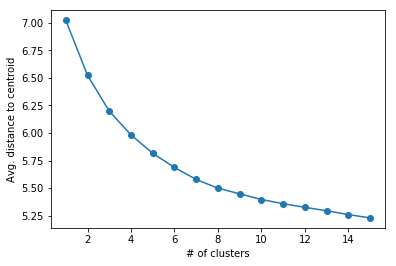

In [197]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
from sklearn.cluster import KMeans

cluster_nums = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
distances = []

for c in cluster_nums:
    print('evaluating for {} clusters'.format(c))
    
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=c)
    
    preds = kmeans.fit_predict(pca_X_df)
    #print(preds)
    # compute the average within-cluster distances.
    pred_centroids = kmeans.cluster_centers_
    #print(pred_centroids)
    centers = pred_centroids[preds]
    #print(centers)
    distance = np.sqrt(((pca_X_df - centers) ** 2).sum(axis = 1)).mean()
    distances.append(distance)
    
plt.plot(cluster_nums, distances, '-o')
plt.ylabel('Avg. distance to centroid')
plt.xlabel('# of clusters')
plt.savefig('distance_to_centroid.png')


In [198]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=8)
model = kmeans.fit(pca_X_df)
pred_azdias = model.predict(pca_X_df)

### Discussion 3.1: Apply Clustering to General Population

I use 1-15 to centroids for Kmeans, 8 seems to be Elbow joint. Using 8 for the model

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [199]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [200]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

clean_customers = clean_data(customers)

In [204]:
scale_customers = feature_scaling(clean_customers)

In [206]:
pca_X_customers = pca.transform(scale_customers)
pca_X_customers_df = pd.DataFrame(data=pca_X_customers)

In [207]:
prediction_of_customer = model.predict(pca_X_customers_df)

In [208]:
prediction_of_customer

array([4, 1, 4, ..., 4, 7, 4], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

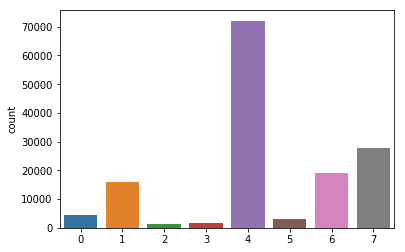

In [209]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
sns.countplot(prediction_of_customer)

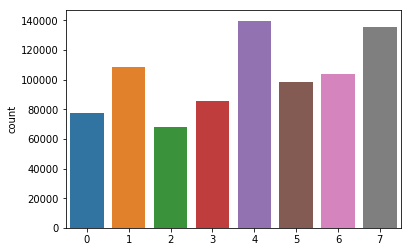

In [212]:
sns.countplot(pred_azdias)

In [214]:
def plot_scaled_comparison(df_sample, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
    pca_reduced.inverse_transform(kmeans.cluster_centers_[cluster]))), orient='index').rename(
    columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');

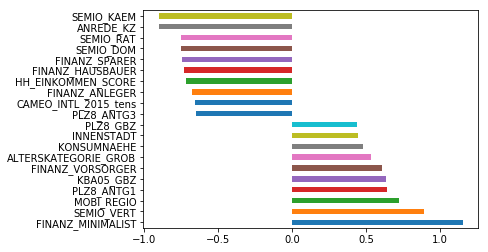

In [216]:
plot_scaled_comparison(scale_customers, model, 4)

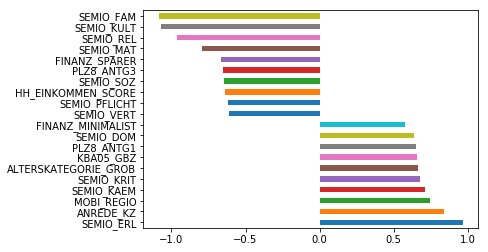

In [218]:
plot_scaled_comparison(scale_customers, model, 7)

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Cluster no 4 is overpresented
# FINANZ_MINIMALIST is the the most notable feature (Low Financial Interest)

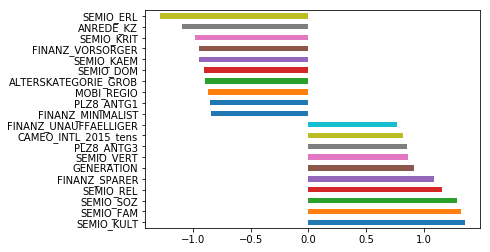

In [217]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

plot_scaled_comparison(scale_customers, model, 2)
#Cluster no 2 is underpresented
# SEMIO_KULT or culture or family or religin minded people are most notable feature

### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster no 4 and 7 related people who are money sparer, even oriented , dreamful, combative attitude, critical minded, People living in Plz8 are more likely customers

Cluster no 2 which is mainly dominated feature being Culturally or Religious oriented are less lik

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.